# Анализ и предсказание продаж по компьютерным играм.

Анализируем и предсказываем продажи интернет магазина компьютерных игр на основе данных до 2016 года. 

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

План:
1. Ознакомление с датасетом
2. Подготовление данных к анализу
3. Исследовательский анализ данных
4. Исследование продаж жанров и платформ по разным регионам
5. Проверяем гипотезы
6. Вывод

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('games.csv')

### Ознакомление с датасетом
* .head()
* .info()
* .describe()
* .hist()

In [3]:
df.head()

Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df.describe()

Year_of_Release      NA_sales      EU_sales      JP_sales  \
count     16446.000000  16715.000000  16715.000000  16715.000000   
mean       2006.484616      0.263377      0.145060      0.077617   
std           5.877050      0.813604      0.503339      0.308853   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2016.000000     41.360000     28.960000     10.220000   

        Other_sales  Critic_Score  
count  16715.000000   8137.000000  
mean       0.047342     68.967679  
std        0.186731     13.938165  
min        0.000000     13.000000  
25%        0.000000     60.000000  
50%        0.010000     71.000000  
75%        0.030000     79.000000  
max       10.570000     98.000000

### Подготовка данных к анализу

#### Приведем названия столбцов к нижнему регистру

In [6]:
df.columns = df.columns.str.lower()

#### Обработаем пропуски и преобразуем данные в нужные типы
    1) year_of_release –– приведем к целочисленному типу int
    2) critic_score –– приведем к целочисленному типу int
    3) user_score –– указан тип object, а нам нужен тип float
   
Как видно на графике и таблице внизу, в столбцах **critic_score**, **user_score** и **rating** пропущенна половина значений. В столбце **year_of_release** пропущенно 269 значений, что составляет 1,6% от длины всего датасета, да и не особо то нам этот столбец пригодится (дальше посмотрим)

* **critic_score** –– оценка критиков. Можно заполнить значения NaN нулями. Благо нулевой оценки у нас в датасете нету (проверили выше), значит не спутаем NaN с реальной оценкой
* **user_score** –– оценка пользователей. Аналогичные рассуждения как для оценки критиков
* **rating** –– рейтинг ESRB. Можно было бы предположить, что там, где обнаружены пропуски, в тех годах ESRB еще не существовала, но нет. Эта компания существует с 94-го, а пропусков больше всего по годам, которые позднее 1994. Тогда можно предположить, что какие-то игры не удостаиваются оценки ESRB (малоизвестные, например, или те игры, которые выпускаются на малоизвестных платформах)

Также заметим, что по каждой игре, по которой отсутствует оценка критиков **critic_score**, отсутствуют и две другие оценки

По столбцам **name** и **genre**, где есть пропущенные значения, можно удалить строки, тк их в сумме всего 4

0
critic_score  51.319174
user_score    40.089740
rating        40.478612

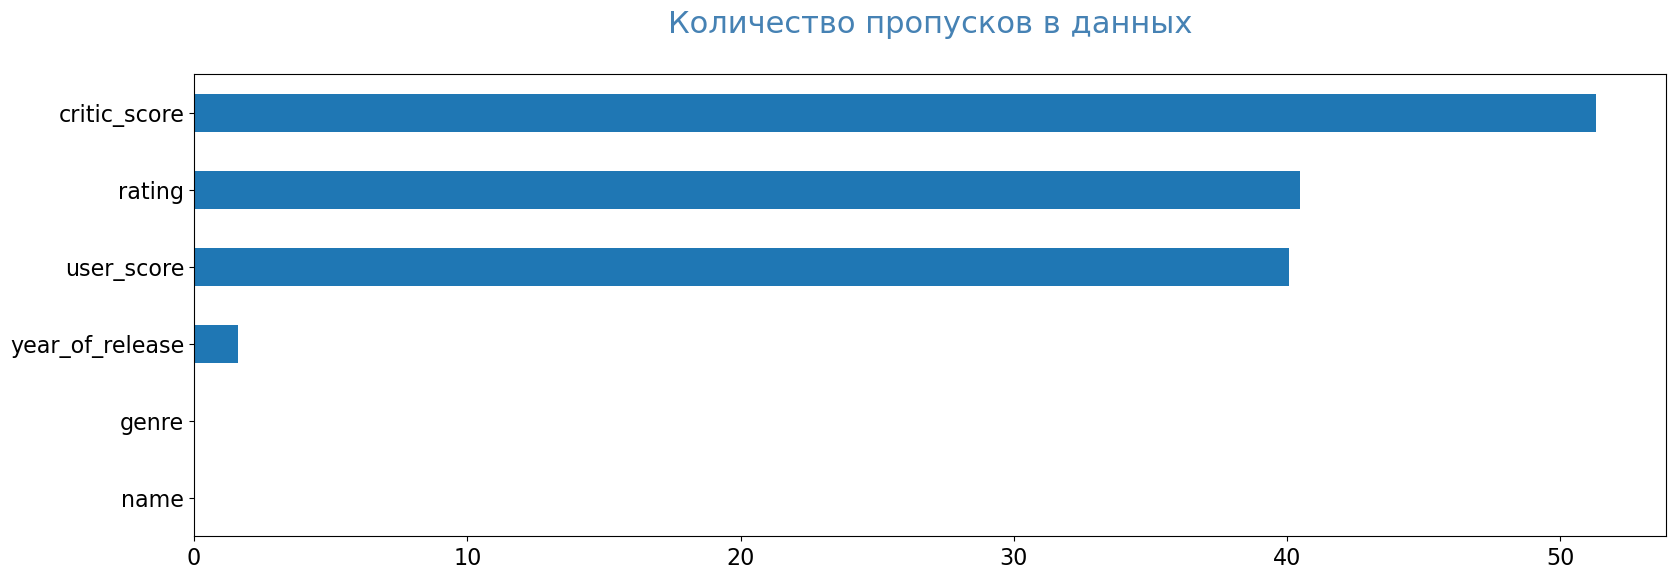

In [7]:
def isna_barh(df):
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
            .set_title('Количество пропусков в данных' + "\n", fontsize = 22, color = 'SteelBlue')    
        );
isna_barh(df)
(df.isna().mean()*100).to_frame()[-3:]

 В столбцах **genre**, **name** незначительное количество пропусков, а по столбцу **year_of_release** пропуски составляют не больше 3% от общего датасета. Можем их удалить:

In [8]:
df = df.loc[(df['name'].notna()) & (df['genre'].notna()) & (df['year_of_release'].notna())]
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

In [9]:
df['year_of_release'] = df['year_of_release'].astype('int')
df['critic_score'] = df['critic_score'].fillna(0).astype('int')
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score         6605
rating             6676
dtype: int64

tbd –– аббревиатура **To Be Determined**. Приписывается, когда игра имеет мало количество отзывов для подсчета рейтинга, соответственно, это то же, самое, что и NaN. Переведем все значения tbd в NaN

In [10]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan
df['user_score'] = df['user_score'].fillna(0).astype('float')
df['rating'] = df['rating'].fillna('no info')
df.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

#### Уберем дубликаты

In [11]:
df.duplicated().sum()

0

#### Посчитаем суммарные продажи во всех регионах

In [12]:
pd.set_option('mode.chained_assignment', None)
df['sales_total'] = df.loc[:,['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [13]:
# Посмотрим, что у нас осталось
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
    print('-'* 25)
    print(col_l, temp[col_l].sort_values().unique())
    print(col_l,' : кол-во 0', temp[temp[col_l] == 0][col_l].count(),
        ', процент 0', round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2),'%')
    print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  sales_total      16444 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
name  

### Исследовательский анализ данных
    1) Распределение кол-ва игр в разные годы
    2) Динамика продаж по платформам
    3) Определить топ платформ по продажам
    4) Изучить зависимость отзывы пользователей и критиков на продажи по топовой платформе
    5) Распределение игр по жанрам

#### Посмотрим, как распределялось количество игр в разные годы

In [14]:
pivot_years = df.pivot_table(
    index = 'year_of_release',
    values = 'name',
    aggfunc = 'count')

pivot_years.columns = ['count']
pivot_years.reset_index(inplace = True)
pivot_years.sort_values(by = 'count', ascending = False).head()

year_of_release  count
28             2008   1427
29             2009   1426
30             2010   1255
27             2007   1197
31             2011   1136

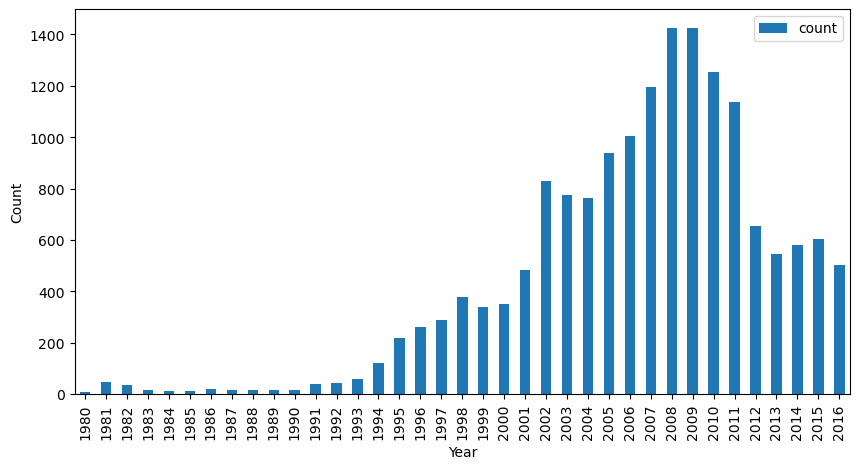

In [15]:
ax = pivot_years[pivot_years['year_of_release']!=0].plot(
    y = 'count',
    x = 'year_of_release',
    kind = 'bar',
    figsize = (10,5));
ax.set_xlabel('Year');
ax.set_ylabel('Count');

    Вывод: Данные за весь период не важны, так как в 80-90х годах было очень мало релизов, игровая индустрия еще только-только зарождалась. Сильный пик наблюдается в 2002 году: развитие технологий, новые движки и платформы, общий спрос на игры возрос кардинально. Максимальное количество релизов было за 2008 год (1417), а затем данные идут на спад. Скорее всего, можно объяснить стремлением компаний создавать более усовершенствованный геймплей, улучшать графику и тд. На это требуется много времени. 

    Актуальный пример: компания CD Project Red. Компьютерную игру Cyberpunk 2077 делали 8 лет (и все равно с огромным количеством багов)

#### Динамика продаж по платформам

In [16]:
pivot_platform = df.pivot_table(
    index = 'platform',
    values = 'sales_total',
    aggfunc = 'sum')
pivot_platform.sort_values(by = 'sales_total', ascending = False).head()

sales_total
platform             
PS2           1233.56
X360           961.24
PS3            931.34
Wii            891.18
DS             802.78

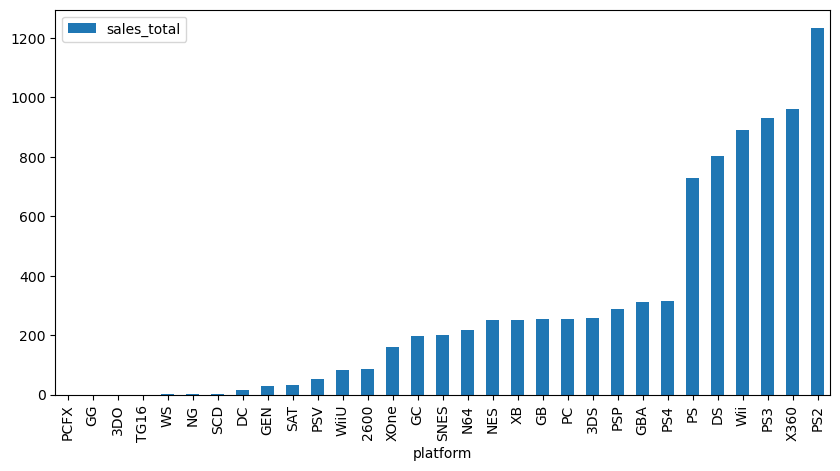

In [17]:
(pivot_platform.
             sort_values(by = 'sales_total', ascending = True)
             .plot(kind = 'bar', figsize = (10,5))
                                                 );

    В топ-1 с большим отрывом выбилась приставка PS2, затем X360, PS3 и Wii

    Посмотрим, как выглядят графики для топ-4 приставок по продажам:

In [18]:
top = ['PS2', 'X360', 'PS3', 'Wii']

def top_platform(list):
    fig = go.Figure()
    for platform in list:
        pivot = (df.loc[(df['platform'] == platform) & (df['year_of_release'] != 0), ['year_of_release', 'sales_total']]
             .pivot_table(
             index = 'year_of_release',
             values = 'sales_total',
             aggfunc = 'sum'))
        pivot.columns = [f'sales_total_{platform}']
        pivot.reset_index(inplace = True)
        fig.add_trace(go.Scatter(x = pivot['year_of_release'], y = pivot[f'sales_total_{platform}'], name = f'Total Sales {platform}'))
    fig.update_layout(
        width=800,
        height=500)
    fig.show()
    
    
top_platform(top)

   Что видно по графику: PS2 жила 11 лет (с 2000 по 2011), X360 жила тоже 11 лет (с 2005 по 2016), PS3 –– 10 лет  (2006-2016), Wii –– 10 лет (2006-2016). Таким образом, приставки живут в среднем 10,5 лет

#### Определим лидеров продаж на в актуальный период, посмотрим, какие платформы падают или растут

Актуальным периодом можно считать последние 4 года, когда количество релизов резко упало и теперь совершенно другое движение рынка. Было бы некорректно брать данные раньше, так как в то время был огромный ажиотаж вокруг компьютерных игр и рынок был перегрет в районе 2007-2008 года. Возьмем данные с 2012 по 2016 год

In [19]:
# Составим список платформ, которые были с 2012 по 2016
platforms = [i for i in df.query('year_of_release >=2012 and year_of_release < 2017')['platform'].unique()]


# Напишем функцию, которая построит графики в промежутке с 2012 по 2016 год (за основу берем функцию top_platform)
def top_platform_12_16(list):
    fig = go.Figure()
    for platform in list:
        pivot = (df.loc[(df['platform'] == platform) & (df['year_of_release'] >= 2012) & (df['year_of_release'] < 2017), ['year_of_release', 'sales_total']]
             .pivot_table(
             index = 'year_of_release',
             values = 'sales_total',
             aggfunc = 'sum'))
        pivot.columns = [f'sales_total_{platform}']
        pivot.reset_index(inplace = True)
        fig.add_trace(go.Scatter(x = pivot['year_of_release'], y = pivot[f'sales_total_{platform}'], name = f'{platform}'))
    fig.update_layout(
        width=800,
        height=500)
    fig.show()
    
top_platform_12_16(platforms)

На 2016 год лидеры продаж: 
* PS4
* XOne
* 3DS

Стоит также заметить, что у всех троих приставок количество продаж уменьшается. Если учитывать, что у топ-3 самая большая доля продаж на рынке, то это говорит об общем тренде рынка, т.е он падает 

#### Построим боксплот по глобальным продажам игр по каждой платформе

In [20]:
df_act = df.query('year_of_release >= 2012 and year_of_release < 2017')

In [21]:
import seaborn as sns

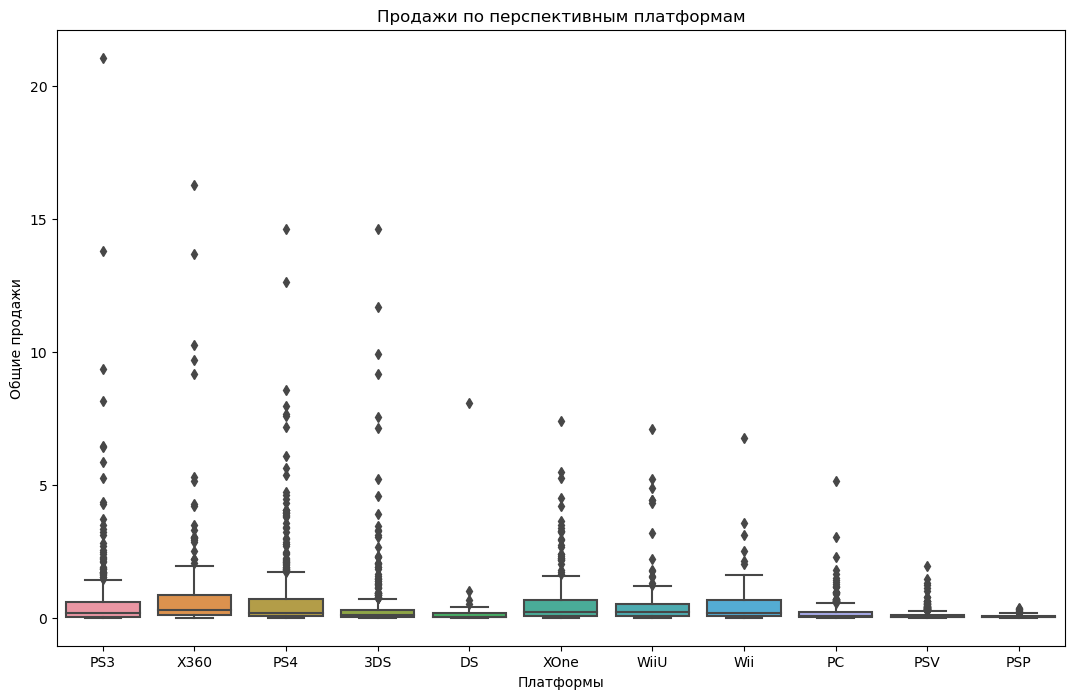

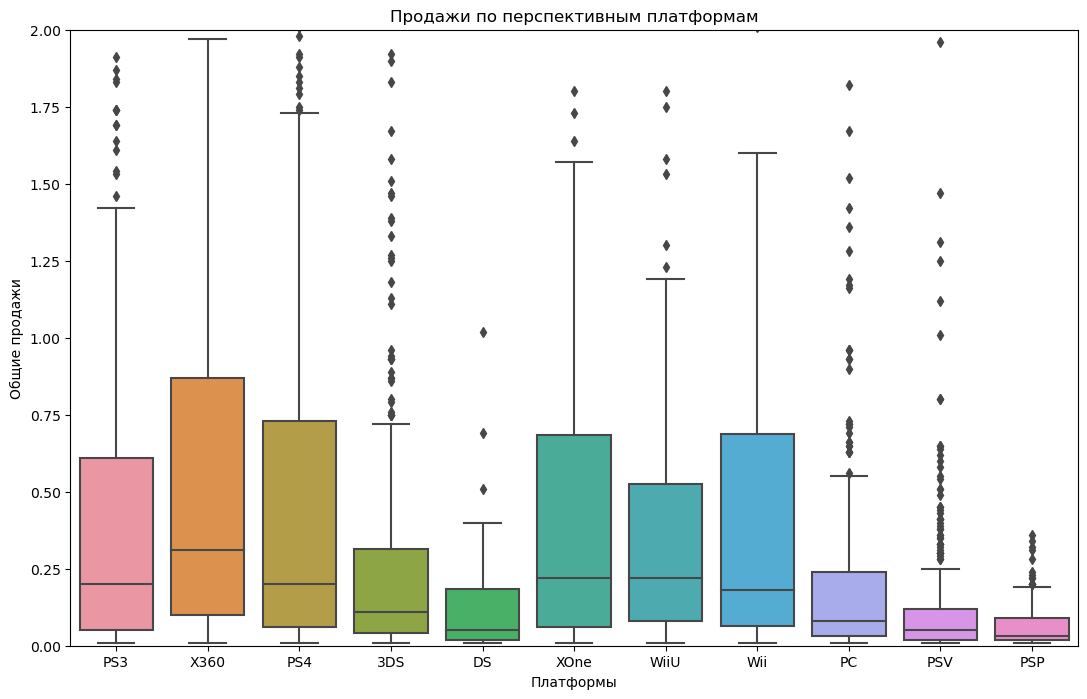

In [22]:
import seaborn as sns
data_temp, y = df_act.copy(), 'sales_total'
plt.figure(figsize=(13, 8))
(sns.boxplot(data = data_temp, y = y, x='platform')
    .set(title = 'Продажи по перспективным платформам', xlabel = 'Платформы', ylabel = 'Общие продажи'))
plt.show()
plt.figure(figsize=(13, 8))
(sns.boxplot(data = data_temp, y = y, x='platform')
    .set(title = 'Продажи по перспективным платформам', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 2)))
plt.show()

    В среднем медиана по платформам колеблется от 0,1 до 0,5 млн долларов. Аномалии у всех разные. У приставки X360 аномалии формируются восле 2 млн долларов, у PS4, XOne, Wii –– после 1,5-1,7 млн долларов. У приставки DS показатели значительно ниже. Медиана меньше 0,1 миллиона, а аномалии формируются после 0,5 млн долларов. У PSP в целом очень маленькие продажи, его можно не включать в топ. PSV продает игры с медианой около 0,1 млн, формирует аномалии после 0,2 млн 

#### Влияние отзывов пользователей и критиков на продажи PS4.

Я выбрал PS4 потому что на момент 2016 года она самая популярная и уже 3 года на рынке. За такой временной диапазон уже должно сформироваться достаточное количество отзывов критиков и пользователей, чтобы отслеживать взаимосвязь с продажами

In [23]:
df_act_ps4 = df_act.loc[(df_act['platform'] == 'PS4')]

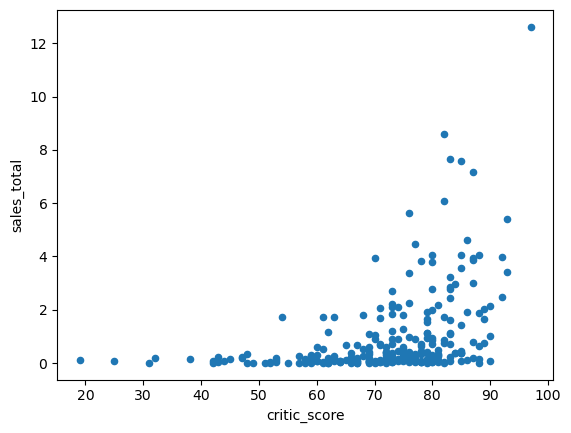

In [24]:
(df_act_ps4.loc[df_act_ps4['critic_score'] > 0]
.plot(kind = 'scatter',
      x = 'critic_score', 
      y = 'sales_total')
);

Как видно, с увеличением оценки критиков, растут и продажи платформы. Оценки критиков служат вполне авторитетным мерилом качества игры, так что вполне очевидная взаимосвязь

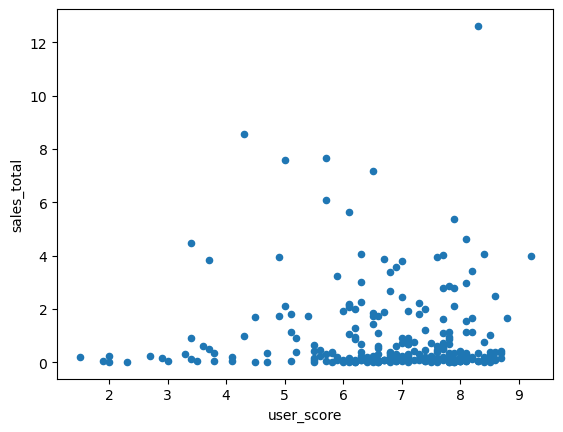

In [25]:
(df_act_ps4.loc[df_act_ps4['user_score'] > 0]
.plot(kind = 'scatter',
      x = 'user_score', 
      y = 'sales_total')
);

По оценке пользователей можно сделать такой же вывод, как и про оценку критиков, но здесь ситуация немного похуже. Корреляция слабее, потому что оценка критиков более авторитетна, чем отзывы пользователей. Несмотря на много плохих отзывов, например, Cyberpunk 2077 все равно хорошо продается 

In [27]:
df_act.loc[(df_act['platform'] == 'PSP'), 'critic_score'].value_counts()

critic_score
0     172
74      1
Name: count, dtype: int64

По платформе PSP видно, что в 172 из 173 строках стоят нули по оценке критиков. Мы их сами заполнили –– на их месте сейчас стоял бы NaN. Из таких данных корреляцию не вычислить

In [29]:
df_act.loc[(df_act['platform'] == 'DS'), 'critic_score'].value_counts()

critic_score
0     30
80     1
Name: count, dtype: int64

То же самое для платформы DS. 30 нулей в 31 строке. Круто

3DS


user_score     0.197583
sales_total    1.000000
Name: sales_total, dtype: float64

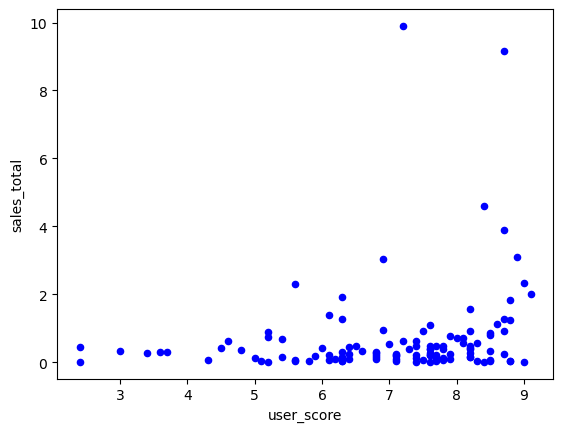

critic_score    0.320803
sales_total     1.000000
Name: sales_total, dtype: float64

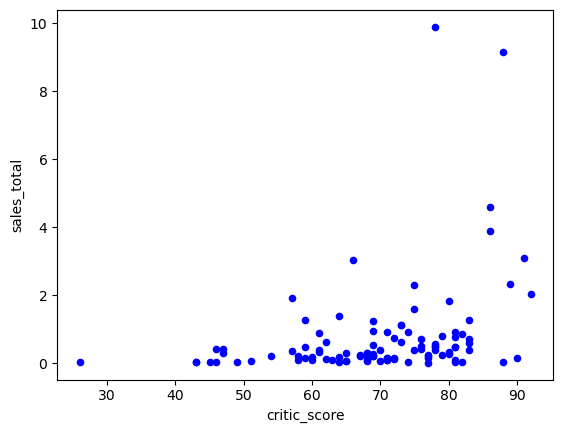

DS
Для платформы DS не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей
Для платформы DS не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
PC


user_score    -0.121867
sales_total    1.000000
Name: sales_total, dtype: float64

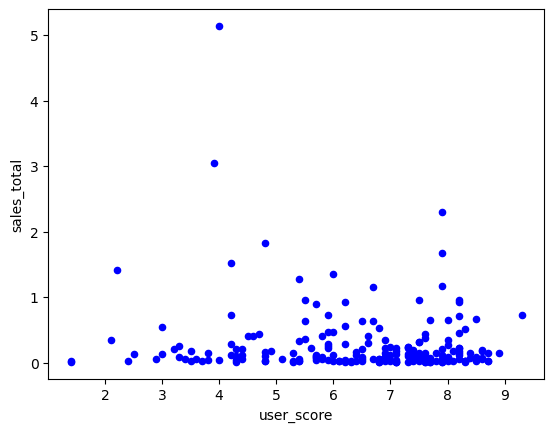

critic_score    0.237243
sales_total     1.000000
Name: sales_total, dtype: float64

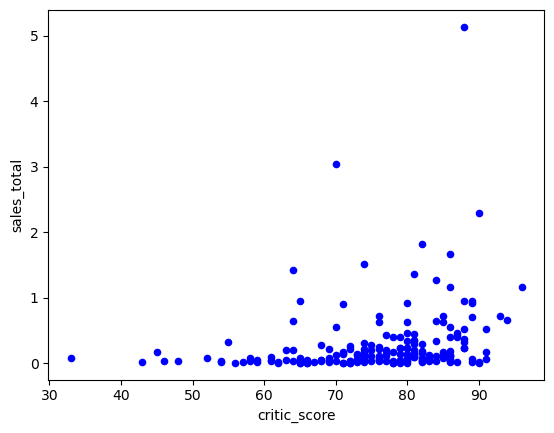

PS3


user_score    -0.005144
sales_total    1.000000
Name: sales_total, dtype: float64

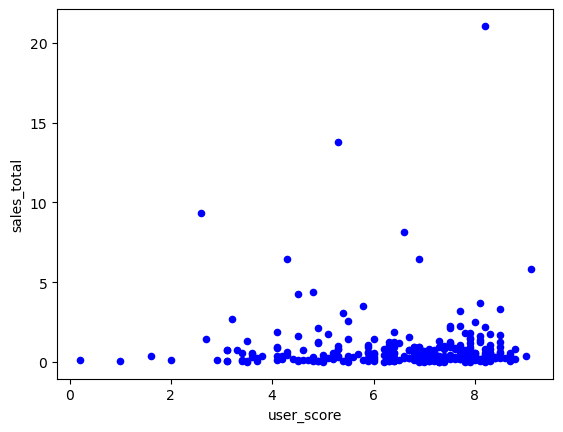

critic_score    0.331497
sales_total     1.000000
Name: sales_total, dtype: float64

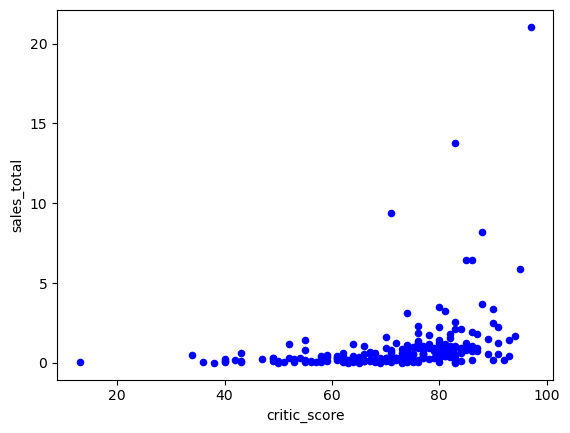

PS4


user_score    -0.031957
sales_total    1.000000
Name: sales_total, dtype: float64

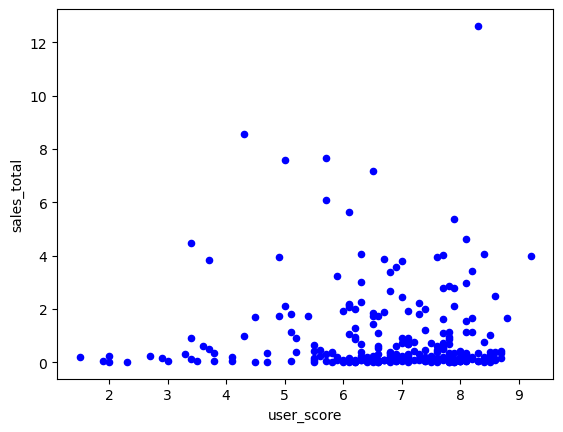

critic_score    0.406568
sales_total     1.000000
Name: sales_total, dtype: float64

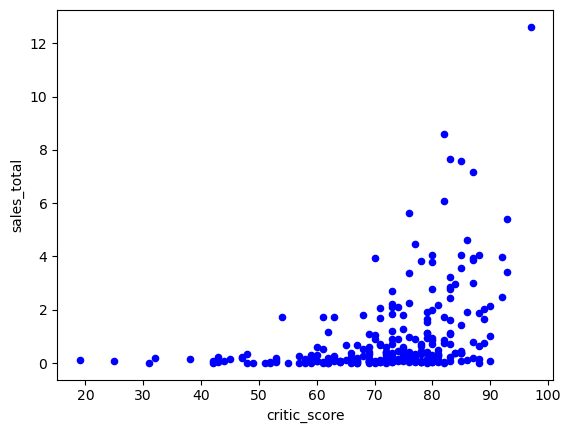

PSP


user_score    -0.802302
sales_total    1.000000
Name: sales_total, dtype: float64

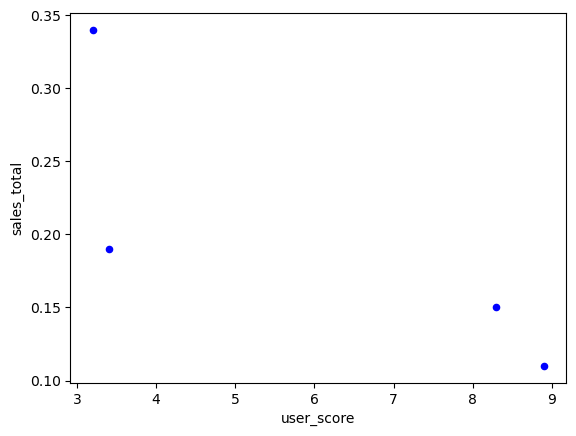

Для платформы PSP не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
PSV


user_score    -0.004339
sales_total    1.000000
Name: sales_total, dtype: float64

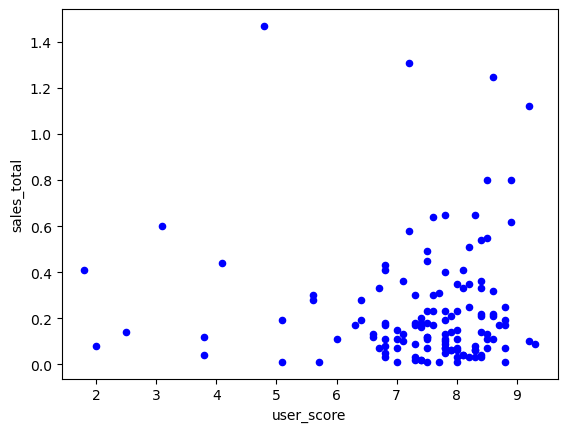

critic_score    0.094488
sales_total     1.000000
Name: sales_total, dtype: float64

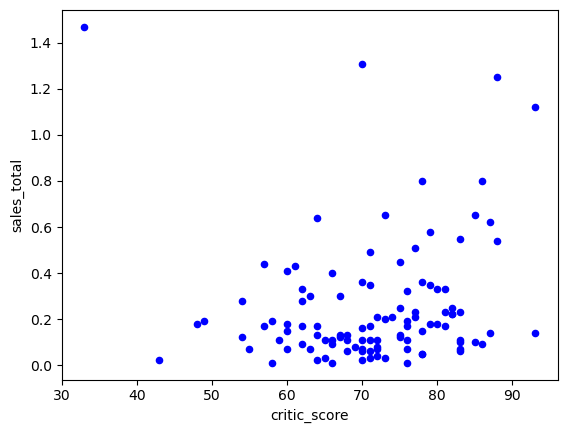

Wii


user_score     0.296197
sales_total    1.000000
Name: sales_total, dtype: float64

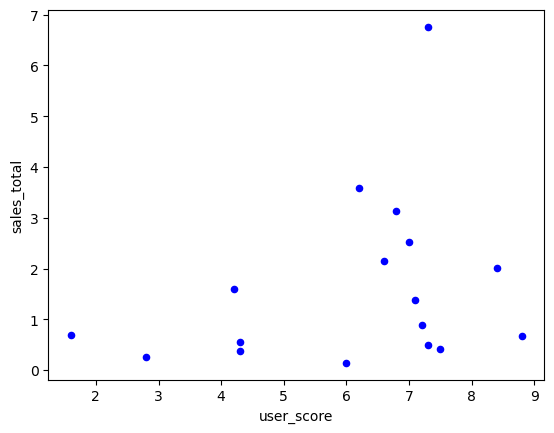

critic_score   -0.424341
sales_total     1.000000
Name: sales_total, dtype: float64

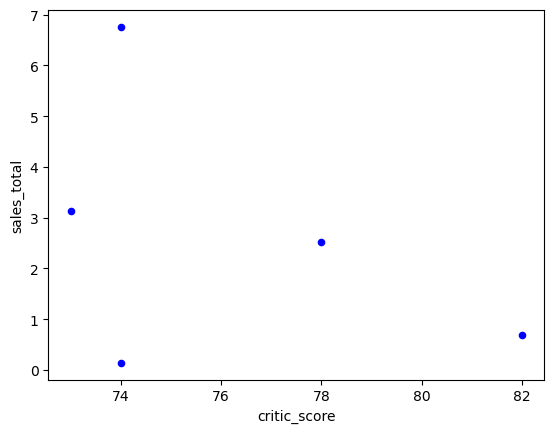

WiiU


user_score     0.400219
sales_total    1.000000
Name: sales_total, dtype: float64

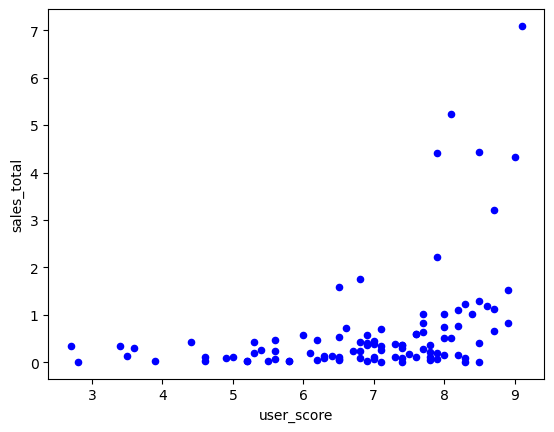

critic_score    0.34838
sales_total     1.00000
Name: sales_total, dtype: float64

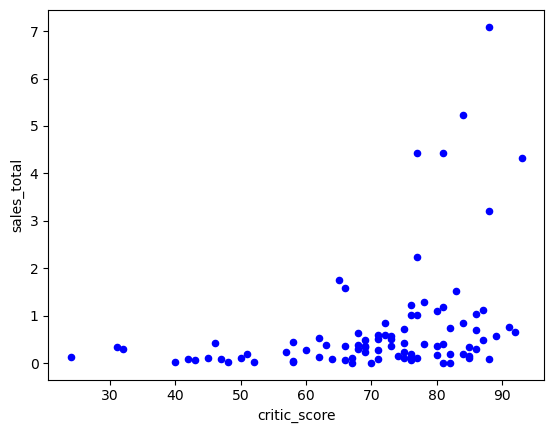

X360


user_score     0.006164
sales_total    1.000000
Name: sales_total, dtype: float64

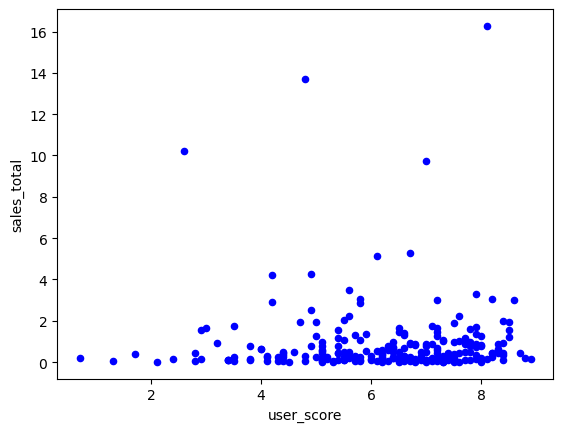

critic_score    0.360573
sales_total     1.000000
Name: sales_total, dtype: float64

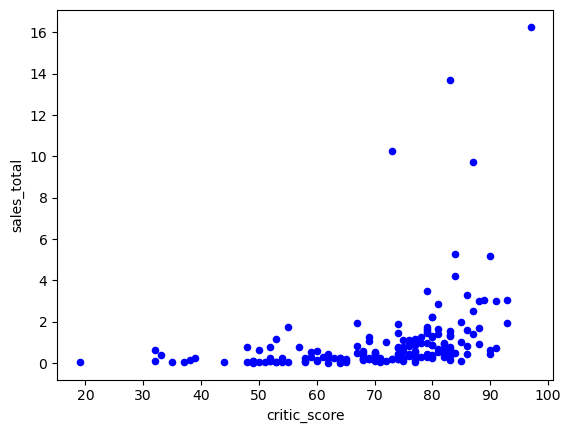

XOne


user_score    -0.068925
sales_total    1.000000
Name: sales_total, dtype: float64

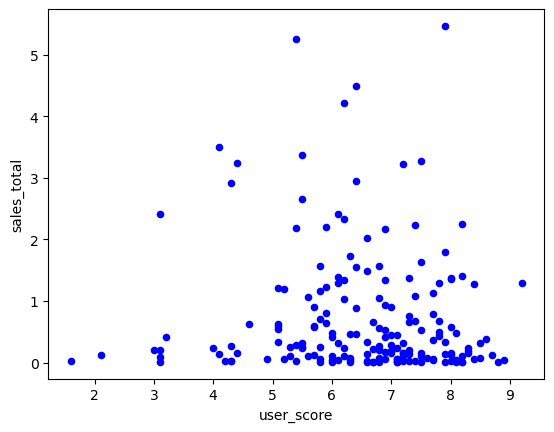

critic_score    0.416998
sales_total     1.000000
Name: sales_total, dtype: float64

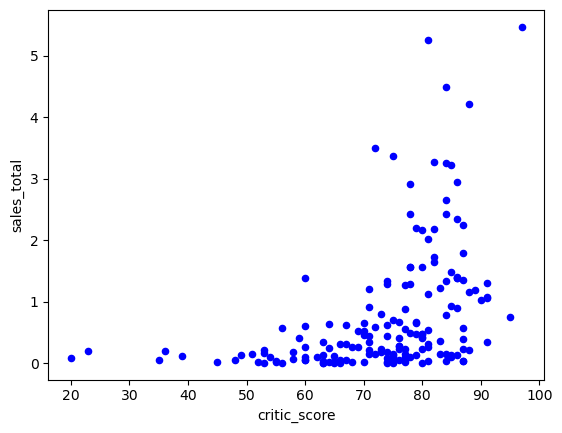

In [30]:
import matplotlib.pyplot as plt
df_sc, y = df_act.copy(), 'sales_total'
for platform, games_on_pl in df_sc.groupby('platform'):
    print('='*60)
    print(platform)
    # Считаем сколько в колонке не пустых отзывов
    not_user = len(games_on_pl[(games_on_pl.user_score > 0)&(games_on_pl['user_score'].notna() == True)])
    not_critic = len(games_on_pl[(games_on_pl.critic_score > 0)&(games_on_pl['user_score'].notna() == True)])
    sum_not = 3 # Задаем количество не пустых значений для вывода диаграммы и расчета корреляции
    if not_user > sum_not:
        games_on_pl[games_on_pl.user_score > 0].plot(kind='scatter', x='user_score', y=y, color='b')
        display(games_on_pl[games_on_pl.user_score > 0][['user_score', y]].corr()[y])
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей')
    if not_critic > sum_not:
        games_on_pl[games_on_pl.critic_score > 0].plot(kind='scatter', x='critic_score', y=y, color='b')
        display(games_on_pl[games_on_pl.critic_score > 0][['critic_score', y]].corr()[y])
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов критиков')

#### Посмотрим на распраделение игр по жанрам. Определим самые прибыльные

Смотрим на общую сумму продаж:

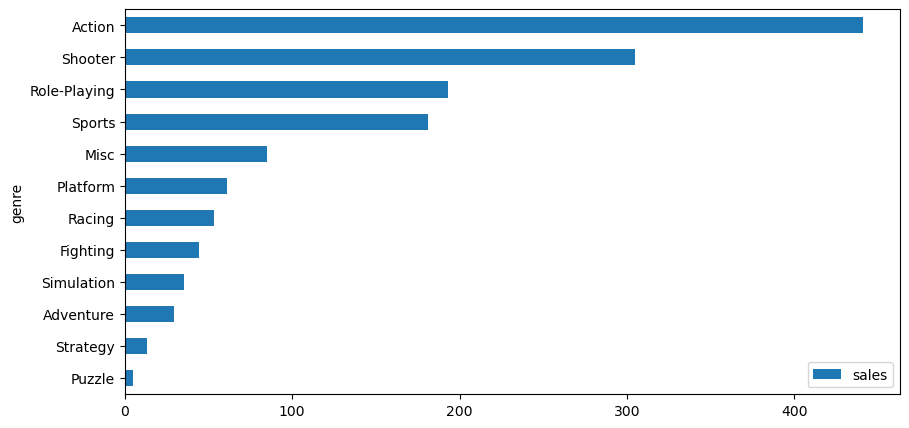

In [31]:
df_genre_sum = df_act.pivot_table(index = 'genre', values = 'sales_total', aggfunc = 'sum')
df_genre_sum.columns = ['sales']
df_genre_sum.sort_values(by = 'sales', ascending = True).plot(kind = 'barh', figsize = (10,5));

Смотрим на общее количество продаж:

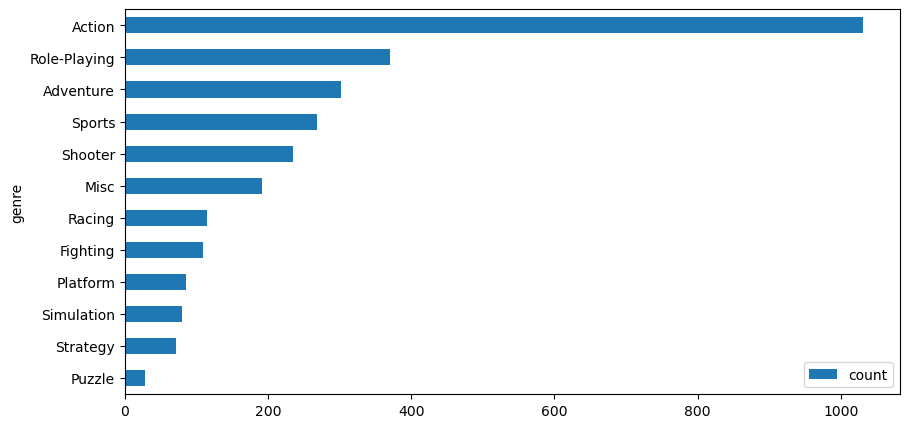

In [32]:
df_genre_count = df_act.pivot_table(index = 'genre', values = 'sales_total', aggfunc = 'count')
df_genre_count.columns = ['count']
df_genre_count.sort_values(by = 'count', ascending = True).plot(kind = 'barh', figsize = (10,5));

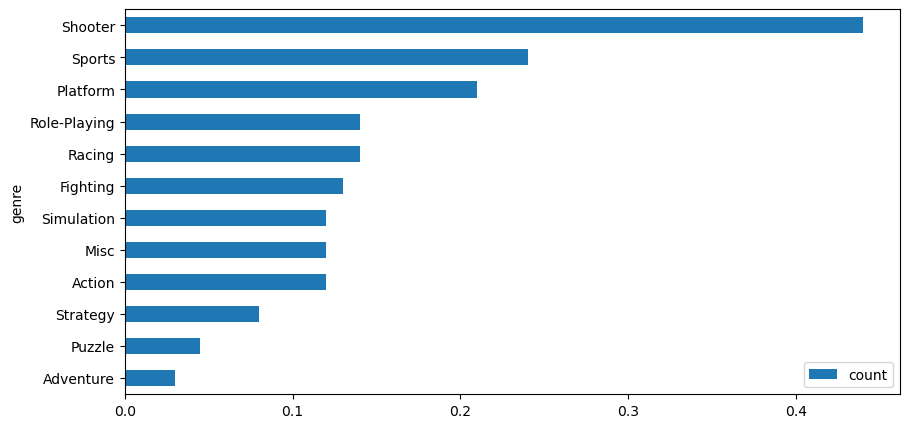

In [33]:
df_genre_count = df_act.pivot_table(index = 'genre', values = 'sales_total', aggfunc = 'median')
df_genre_count.columns = ['count']
df_genre_count.sort_values(by = 'count', ascending = True).plot(kind = 'barh', figsize = (10,5));

Составим топ-3 по количеству и сумме общих продаж:

*Сумма продаж*: 
* **Action** 
* **Shooter** 
* **Role-Playing**


*Количество продаж*:
* **Action**
* **Role-Playing**
* **Adventure**


Жанр **Action** абсолютный лидер среди жанров по количеству и сумме продаж. Жанр **Shooter** в рейтинге суммы продаж занимает второе место, а в количестве продаж – только пятое. Это говорит нам о том, что игры жанра **Shooter** дороже, чем **Role-Playing** и **Sports** (если сравнить количество и сумму продаж по этим жанрам, то видно, что **Shooter** продали меньше, чем остальные два, а выручка больше)

### Портрет пользователя каждого региона (NA, EU, JP)
* Выявить топ-5 популярных платформ
* Выявить топ-5 жанров
* Определить влияние рейтинга ESRB на продажи по каждому региону

#### Топ-5 популярных платформ 

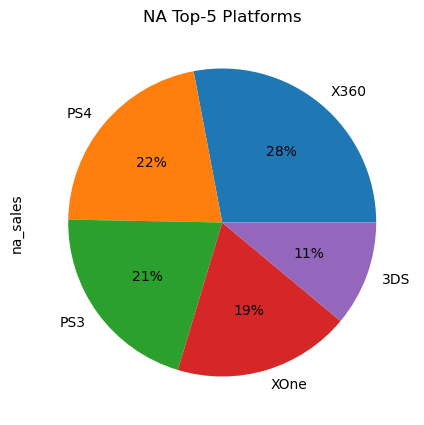

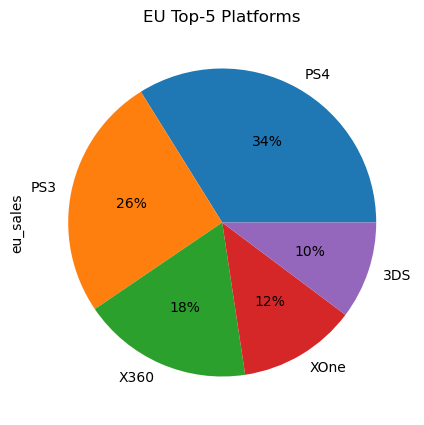

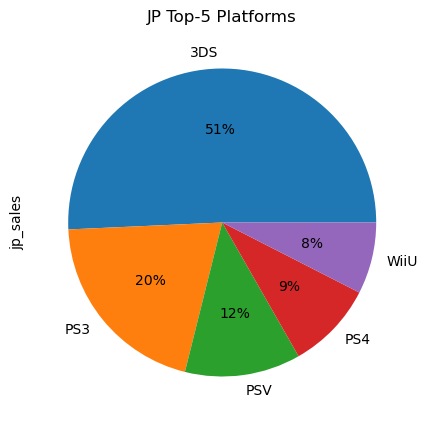

In [34]:
regions = ['na', 'eu', 'jp']
for region in regions:
    pivot_platform = df_act.pivot_table(
    index = 'platform',
    values = f'{region}_sales',
    aggfunc = 'sum')
    
    (pivot_platform.sort_values(by = f'{region}_sales', ascending = False).head()
     .plot(kind = 'pie',subplots = True, figsize = (10,5), legend = False, autopct='%1.0f%%'))
    plt.title(f'{region.upper()} Top-5 Platforms')
plt.show()

**NA**: В Северной Америке топ-1 и топ-2 занимали **X360** и **PS2** соответственно. **X360** выходит в топ-1 с небольшим отрывом. Далее идет **Wii**, и уже с большим отрывом идут **PS3** и **DS**

**EU**: В Европе все как у нормальных людей: сначала идет легендарная **PS2** (примерно на 340 млн долларов продаж), рядом идет **PS3**, а уже только потом **X360**, продажи которого составили примерно 275 млн долларов. Остальные два в топе это **Wii** и **PS**

**JP**: В Японии самой популярной платформой была **DS** - продаж на 175 млн долларов, значительный отрыв от топ-2 и топ-3: **PS** и **PS2**. Топ-4 и топ-5 занимают ноунеймы, скорее всего, японские))

#### Топ-5 жанров

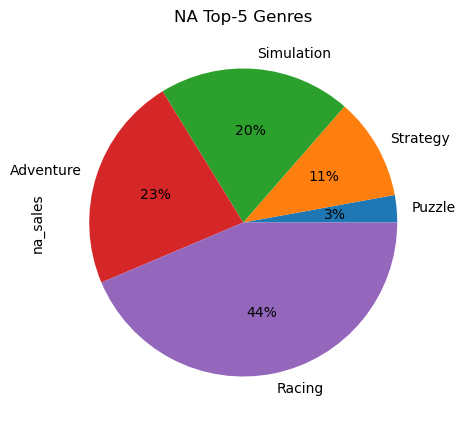

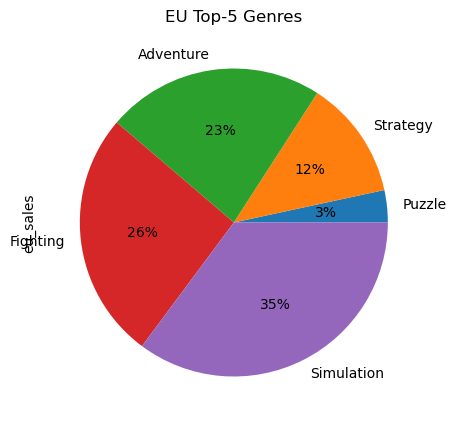

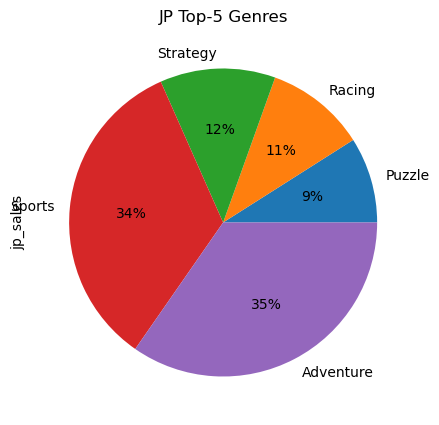

In [35]:
regions = ['na', 'eu', 'jp']
for region in regions:
    pivot_platform = df_act.pivot_table(
    index = 'genre',
    values = f'{region}_sales',
    aggfunc = 'sum')
    col_dict = {'na_sales': None, 'eu_sales': 'red', 'jp_sales': 'violet'}
    title_dict = {'na_sales' : 'North America Genres', 'eu_sales' : 'Europe Genres', 'jp_sales': 'Japan Genres'}
    
    (pivot_platform.sort_values(by = f'{region}_sales').head()
     .plot(kind = 'pie',subplots = True, figsize = (10,5), legend = False, autopct='%1.0f%%'))
    plt.title(f'{region.upper()} Top-5 Genres')
plt.show()


Вкусы в Европе и Северной Америке очень похожи: больше всего фанатов **Action**, **Sports** и **Shooter**. Дальше в топе у Северной Америки жанр **Platform**, а у Европы –– **Racing**. Как я и говорил, самые ровные геймеры в Европе. 

В Японии отличается от Европы и Америки. В Японии больше всего фанатов **Role-Playing**, **Action** и **Sports**

У всех трех на последнем месте жанр **Misc**


#### Влияние рейтинга ESRB на продажи в отдельном регионе

Рейтинг ESRB имеет следующие критерии: 
* **E** –– для всех возрастов 
* **T** –– для лиц старше 13 лет
* **M** –– для лиц старше 17 лет
* **E10+** –– для лиц старше 10 лет
* **EC** –– для лиц от 3 лет
* **RP** –– рейтинг еще не присвоен
* **K-A** –– для лиц от 6 лет
* **AO** –– для лиц старше 18 лет

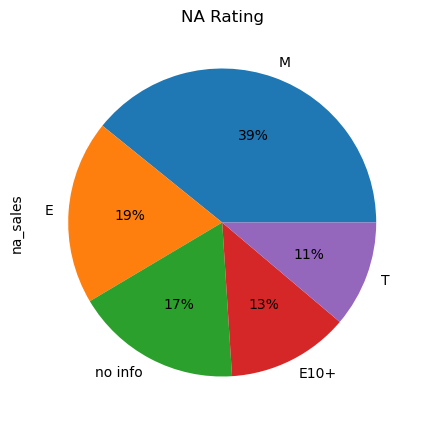

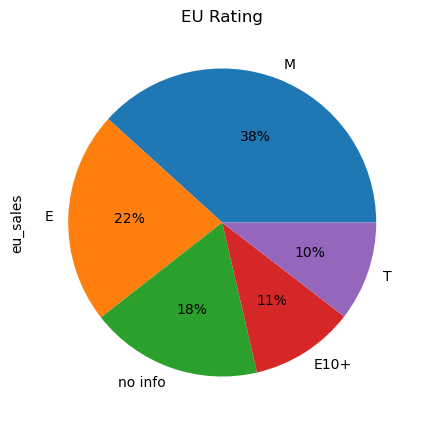

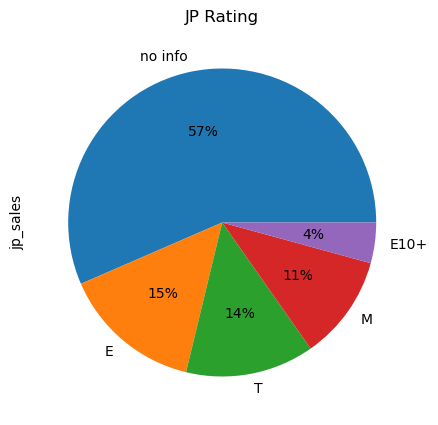

In [36]:
regions = ['na', 'eu', 'jp']
for region in regions:
    pivot_platform = df_act.pivot_table(
    index = 'rating',
    values = f'{region}_sales',
    aggfunc = 'sum')
    col_dict = {'na_sales': None, 'eu_sales': 'red', 'jp_sales': 'violet'}
    (pivot_platform.sort_values(by = f'{region}_sales', ascending = False)
     .head()
     .plot(kind = 'pie',subplots = True, figsize = (10,5), legend = False, autopct='%1.0f%%'))
    plt.title(f'{region.upper()} Rating')
plt.show()

Сгруппировали по рейтингу ESRB. Картина такая: У Северной Америки и Японии одинаковые топы, правда сильно различающиеся в показателях. В Северной Америке с рейтингом **E** (для всех) свыше 1200, а у Японии –– чуть ниже 200. Далее категория **T** (>13) –– 150 в Японии, в Северной Америке –- чуть около 700. Категория **M** (>18) в Японии –– чуть больше 60, в Северной Америке –- почти как категория **T**. Категория **K-A** (>6) занимает мизерную долю что в Японии, что в Северной Америке

По Европе: Категория **E** доминирует (свыше 700), затем идет **M** и **T** (близки по количеству игры), затем поменьше игр категории **E10+** (>10), около 200. Последняя в топе, кстати, категория **AO** (>18)

### Проверяем гипотезы
* Средние у user_score по платформам **XOne** и **PC** одинаковые
* Средние у user_score по жанрам **Action** и **Sports** одинаковые

Возьмем стандартный уровень значимости 5% и для сравнения двух генеральных выборок с одинаковыми дисперсиями. Так как дисперсии мы сами не знаем, мы используем несмещенные оценки этих дисперсий. Как известно, для тестирования гипотез о равенстве двух средних с равными, но неизвестными дисперсиями, используется t-критерий Стьюдента. 

In [37]:
from scipy import stats as st

In [38]:
def t_stat(group, name_1, name_2, sign_lev):
    alpha = sign_lev
    
    sample_1 = df_act.loc[(df_act[group] == name_1) & (df['user_score'] > 0), 'user_score']
    sample_2 = df_act.loc[(df_act[group] == name_2) & (df['user_score'] > 0), 'user_score']

    results = st.ttest_ind(sample_1, sample_2)
    
    if results.pvalue < alpha:
        return 'Reject the null hypothesis'
    else:
        return 'Not reject the null hypothesis'


$H_{0}: \mu_{XOne} = \mu_{PC}$ (Средние пользовательские рейтинги платформ XOne и PC равны)

$H_{1}: \mu_{XOne} \ne \mu_{PC}$ (Средние пользовательские рейтинги платформ XOne и PC не равны)

$\alpha = 0.05$

Проверяем двустороннюю гипотезу

In [39]:
t_stat('platform', 'XOne', 'PC', 0.05)

'Not reject the null hypothesis'

Вывод: Не отвергаем нулевую гипотезу, значит средние пользовательские рейтинги **XOne** и **PC** равны

$H_{0}: \mu_{Action} = \mu_{Sports}$ (средние пользовательские рейтинги жанров Action и Sports равны)

$H_{1}: \mu_{Action} \ne \mu_{Sports}$ (средние пользовательские рейтинги жанров Action и Sports не равны)

$\alpha = 0.05$

Проверяем двустороннюю гипотезу

In [40]:
t_stat('genre', 'Action', 'Sports', 0.05)

'Reject the null hypothesis'

Вывод: Отвергаем нулевую гипотезу, значит средние пользовательские рейтинги жанров **Action** и **Sports** не равны

### Общий вывод

1. Изучили датасет
2. Подготовили данные к анализу:
    * Привели названия столбцов к нижнему регистру
    * Пропуски были обнаружены по большей части в столбцах **year_of_release**, **user_score**, **critic_score**, **rating**. Пропуски в столбцах **user_score**, **critic_score** заполнили нулями (предварительно убедившись что среди оценок нету нулей, чтоб не спутать)
    * Посчтитали суммарные продажи по всем регионам и добавили эти значения в отдельный столбец датасета
3. Исследовали данные:
    * Проследили динамику развития индустрии компьютерных игр: в 80-90е количество выпускаемых игр незначительно. Сильный пик наблюдается в 2002 году. Максимальное количество релизов было за 2008 год (1417), а затем данные идут на спад.
    * Исследовали динамику продаж по платформам: Лидерами по продажам игр являются **PS2**, **X360**, **PS3** и **Wii**.
    * Посмотрели данные за 2012-2016 года. В лидерах продаж платформы **PS4**, **XOne**, **3DS**. У всех трех платформ продажи падают, а значит весь рынок игровой индустрии падает
    * Построили гистограммы по платформам, фигурирующим с 2012 по 2016 год. У топовых платформ медиана по продажам 0,2-0,3 млн, а аномалии формируются на 1,8 млн долларах в среднем
    * Посмотрели, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Наблюдается неплохая корреляция с отзывами критиков (0,4), в то время как отзывы пользователей большой роли не играют или влияют меньше, чем отзывы критиков. Для топовых платформ наблюдается схожая тенденция
    * Изучили распределение продаж игр по жанрам. В топе суммарных продал жанры **Action**, **Shooter**, **Role-Playing**.  В топе по количеству продаж **Action**, **Role-Playing** и **Adventure**
4. Составили портрет пользователя каждого региона
    * По Северной Америке: любители платформ **X360** и **PS2**, фанаты жанров **Action** и **Sports**. Большая часть игр выпускается с ESRB-рейтингом **E** (для всех) и **T** (>13)
    * По Европе: любители платформ **PS2** и **PS3**, фанаты жанров **Action** и **Sports**. Большая часть игр выпускается с ESRB-рейтингом **E** (для всех) и **M** (>17)
    * По Японии: любители платформ **DS** и **PS**, фанаты жанров **Role-Playing** и **Action**. Большая часть игр выпускается с ESRB-рейтингом **E** (для всех) и **T** (>13)
5. Проверили гипотезы о:
    * равенстве средних отзывов пользователей по платформам **XOne** и **PC** : отвергаем гипотезу
    * равенстве средних отзывов пользователей по жанрам **Action** и **Sports** : не отвергаем гипотезу